## Primary Production - Version 2
**Developed for the OOI Data Lab Notebook**

By Sage Lichtenwalner, April 18, 2020

In [ ]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import dask
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import numpy as np

# Setup default plot styles
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Request Data from OOINet

* **Instruments:** 
  * CP04OSSM-RID27-02-FLORTD000 (Chlorophyll-a, Temperature, and Salinity) from the Coastal Pioneer Offshore Surface Mooring
  * CP01CNSM-RID26-07-NUTNRB000 (Nitrate) from the Coastal Pioneer Central Surface Mooring
  * CP03ISSM-SBD11-06-METBKA000 (Shortwave Irradiance) from the Coastal Pioneer Inshore Surface Mooring
* **Time range:** 
  * Four years of data: 2016-01-01 00:00:00 to 2020-01-01 00:00:00


In [ ]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [ ]:
API_USERNAME = ''
API_TOKEN = ''

In [ ]:
# Data Requests - Telemetered
# request_data('CP04OSSM-RID27-02-FLORTD000','telemetered','flort_sample',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CP01CNSM-RID26-07-NUTNRB000','telemetered','suna_dcl_recovered',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CP03ISSM-SBD11-06-METBKA000','telemetered','metbk_a_dcl_instrument',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')

# Recovered (could be used once fall 2019 deployments are added, though flort has a gap)
# request_data('CP04OSSM-RID27-02-FLORTD000','recovered_host','flort_sample',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CP01CNSM-RID26-07-NUTNRB000','recovered_inst','suna_dcl_recovered',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')
# request_data('CP03ISSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2016-01-01T00:00:00.000Z','2020-01-01T00:00:00.000Z')

## 2. Load Data Files

In [ ]:
url_flort = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200419T043545772Z-CP04OSSM-RID27-02-FLORTD000-telemetered-flort_sample/catalog.html'
url_nutnr = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200419T043607428Z-CP01CNSM-RID26-07-NUTNRB000-telemetered-suna_dcl_recovered/catalog.html'
url_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20200419T043625447Z-CP03ISSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html'


In [ ]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  selected_datasets = sorted(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.drop_vars('obs')
  ds = ds.chunk({'time': 1000}) # Used for optimization
  # ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [ ]:
def reject_outliers(data, m=5):
    """
    Reject outliers beyond m standard deviations of the mean.
    :param data: numpy array containing data
    :param m: number of standard deviations from the mean. Default: 3
    """
    stdev = np.nanstd(data)
    if stdev > 0.0:
        ind = abs(data - np.nanmean(data)) < m * stdev
    else:
        ind = len(data) * [True]

    return ind

In [ ]:
%%time
data_flort = get_data(url_flort,'ctdbp')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/usr/local/lib/python3.6/dist-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


CPU times: user 12.3 s, sys: 1.67 s, total: 14 s
Wall time: 60 s


In [ ]:
%%time
data_flort2 = data_flort[['practical_salinity','temp','fluorometric_chlorophyll_a']].to_dataframe()
data_flort2 = data_flort2.resample('1D').mean()

CPU times: user 35.9 s, sys: 7.93 s, total: 43.8 s
Wall time: 1min 15s


In [ ]:
%%time
data_nut = get_data(url_nutnr,'ctdbp')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/usr/local/lib/python3.6/dist-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


CPU times: user 20.9 s, sys: 4.54 s, total: 25.4 s
Wall time: 7min 25s


In [ ]:
%%time
data_nut = data_nut[['salinity_corrected_nitrate']].to_dataframe()
data_nut = data_nut.resample('1D').mean()

CPU times: user 4.94 s, sys: 1.94 s, total: 6.88 s
Wall time: 2min 58s


In [ ]:
%%time
data_met = get_data(url_met,'velpt')
data_met = data_met[['longwave_irradiance','shortwave_irradiance']].to_dataframe()
data_met = data_met.resample('1D').mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/usr/local/lib/python3.6/dist-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


CPU times: user 5.72 s, sys: 619 ms, total: 6.33 s
Wall time: 37.9 s


In [ ]:
# Remove Outliers
data_flort2['practical_salinity'] = data_flort2['practical_salinity'].where(reject_outliers(data_flort2['practical_salinity']))
data_flort2['fluorometric_chlorophyll_a'] = data_flort2['fluorometric_chlorophyll_a'].where(reject_outliers(data_flort2['fluorometric_chlorophyll_a']))
data_nut['salinity_corrected_nitrate'] = data_nut['salinity_corrected_nitrate'].where(reject_outliers(data_nut['salinity_corrected_nitrate']))


In [ ]:
data_met['shortwave_irradiance'] = data_met['shortwave_irradiance'].where(data_met['shortwave_irradiance']<1000)
data_met['shortwave_irradiance'] = data_met['shortwave_irradiance'].where(data_met['shortwave_irradiance']>0)
# data_met['shortwave_irradiance'] = data_met['shortwave_irradiance'].where(reject_outliers(data_met['shortwave_irradiance']))

## 3. Plot the Data

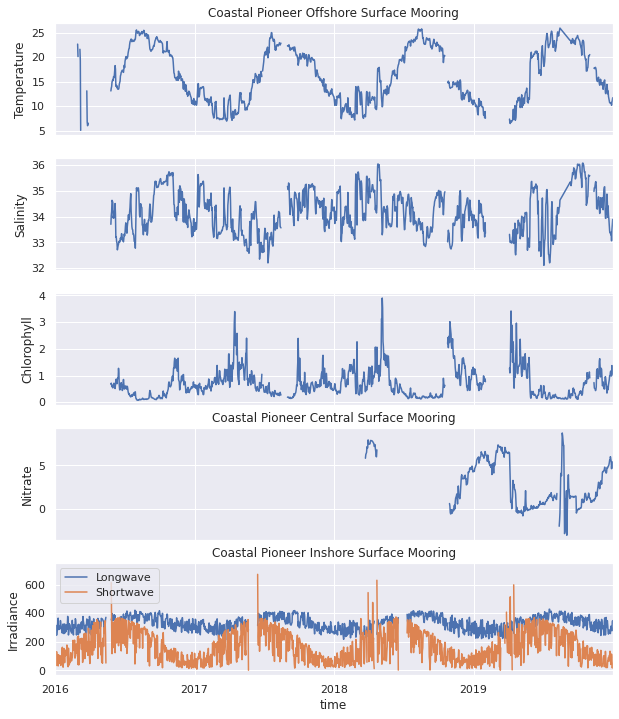

In [ ]:
# Plot Temp, Salinty, Chl, DO, Nitrate, Irradiance
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(10,12))
data_flort2.temp.plot(ax=ax1)
data_flort2.practical_salinity.plot(ax=ax2)
data_flort2.fluorometric_chlorophyll_a.plot(ax=ax3)
data_nut.salinity_corrected_nitrate.plot(ax=ax4)
data_met.longwave_irradiance.plot(ax=ax5,label='Longwave')
data_met.shortwave_irradiance.plot(ax=ax5,label='Shortwave')
ax5.legend();

ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
ax4.set_xlabel('');

ax1.set_ylabel('Temperature');
ax2.set_ylabel('Salinity');
ax3.set_ylabel('Chlorophyll');
ax4.set_ylabel('Nitrate');
ax5.set_ylabel('Irradiance');

ax1.set_title('Coastal Pioneer Offshore Surface Mooring')
ax4.set_title('Coastal Pioneer Central Surface Mooring')
ax5.set_title('Coastal Pioneer Inshore Surface Mooring')

fig.savefig('bio_activity1.png');

## 4. Merge and Export

In [ ]:
# data_flort2 = data_flort2.drop('obs',axis=1)
# data_nut = data_nut.drop('obs',axis=1)
# data_met = data_met.drop('obs',axis=1)

data = data_flort2.merge(data_nut,on='time',how='outer').merge(data_met,on='time',how='outer')
data.head()

,practical_salinity,temp,fluorometric_chlorophyll_a,salinity_corrected_nitrate,longwave_irradiance,shortwave_irradiance
time,,,,,,
2016-03-01,NaN,22.685326,NaN,NaN,271.030090,235.723206
2016-03-02,NaN,20.129663,NaN,NaN,319.400146,41.020458
2016-03-03,NaN,NaN,NaN,NaN,250.614105,240.877090
2016-03-04,NaN,22.152140,NaN,NaN,322.843445,38.382534
2016-03-05,NaN,NaN,NaN,NaN,287.744629,213.558090


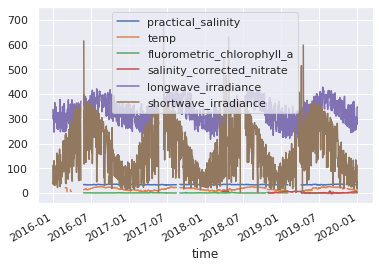

In [ ]:
# Quickplot
data.plot()

In [ ]:
# Export to CSV
data.to_csv('bio_activity1.csv')